<a href="https://colab.research.google.com/github/mafeacero/Reconocimiento-emociones-con-Redes-Neuronales/blob/master/ResNet_Spectogram_An%C3%A1lisis_de_sentimientos_en_Audios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50 para los espectrogramas de los audios


## Carga de los datos

In [0]:
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Ubicación de los datos 
#PATH = '/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Audio'
PATH = '/content/drive/My Drive/Estadistica/Estadistica/Minería de datos/Proyecto Minería de datos/data/Audio'
#PATH = 'G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\data\Audio'

In [0]:
# Loading saved models
import joblib

X = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/X.joblib')
y = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/y.joblib')
mod=joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/mod.joblib')

In [0]:
X1=X[:, 0, :, :]


In [0]:
import tensorflow as tf

# Assuming X and y are initially NumPy arrays
X1 = tf.convert_to_tensor(X1)
y = tf.convert_to_tensor(y)
# Make random permutation
perm = tf.random.shuffle(tf.range(tf.shape(X)[0]))
# Reorder according to permutation
X1 = tf.gather(X1, perm, axis=0)
y = tf.gather(y, perm, axis=0)

## Importar paquetes



In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


## Carga de funciones importantes

In [0]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
   
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

## Definición del modelo ResNet50

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

## Aplicar el modelo

In [0]:
model = ResNet50(input_shape = (223, 217, 3), classes = 8)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
y=[int(i)-1 for i in y]


In [0]:
X1=np.array(X1)
y=np.array(y)
X1.shape


(2452, 223, 217, 3)

In [0]:
y

array([6, 2, 5, ..., 0, 2, 0])

In [0]:
from sklearn.model_selection import train_test_split

X_train_orig, X_test_orig,  Y_train_orig, Y_test_orig=  train_test_split(X1, y, test_size=0.2, random_state=42)

X_train_orig=np.array(X_train_orig)
Y_train_orig=np.array(Y_train_orig)
X_test_orig=np.array(X_test_orig)
Y_test_orig=np.array(Y_test_orig)



In [0]:
Y_train_orig.shape

(1961,)

In [0]:
Y_train_orig=Y_train_orig.reshape((1, Y_train_orig.shape[0]))
Y_test_orig=Y_test_orig.reshape((1, Y_test_orig.shape[0]))

In [0]:
classes=np.array(list(set(y))) # the list of classes


In [0]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 8).T
Y_test = convert_to_one_hot(Y_test_orig, 8).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1961
number of test examples = 491
X_train shape: (1961, 223, 217, 3)
Y_train shape: (1961, 8)
X_test shape: (491, 223, 217, 3)
Y_test shape: (491, 8)


In [0]:
import tensorflow as tf

# Assuming X and y are initially NumPy arrays
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
Y_train = tf.convert_to_tensor(Y_train)
Y_test = tf.convert_to_tensor(Y_test)

# Make random permutation
perm1 = tf.random.shuffle(tf.range(tf.shape(X_train)[0]))
perm2 = tf.random.shuffle(tf.range(tf.shape(X_test)[0]))

# Reorder according to permutation
X_train = tf.gather(X_train, perm1, axis=0)
X_test =tf.gather(X_test, perm2,  axis=0)
Y_train = tf.gather(Y_train, perm1, axis=0)
Y_test = tf.gather(Y_test, perm2, axis=0)


## Ajuste del modelo y predicciones 

In [0]:
history=model.fit(X_train, Y_train, epochs = 21, steps_per_epoch = 32, validation_steps=32, validation_data=(X_test, Y_test))

Train on 1961 samples, validate on 491 samples
Epoch 1/21


In [0]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

491/491 [==============================] - 66s 134ms/step
Loss = 1.41494269429302
Test Accuracy = 0.6985743641853333


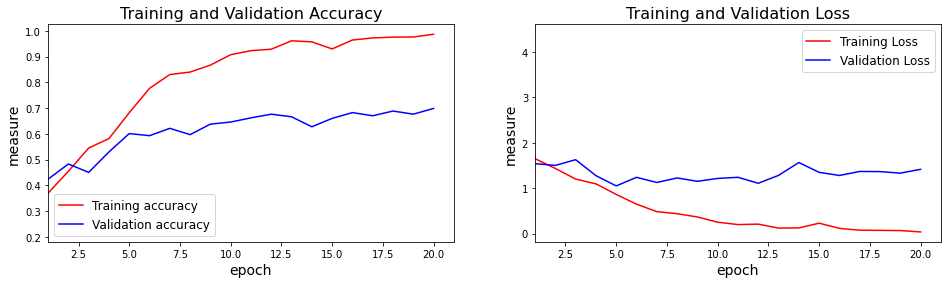

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()

# Solo SPEECH

In [0]:
model = ResNet50(input_shape = (223, 217, 3), classes = 8)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
y=np.asarray(y)

In [0]:
a=[i for i, j in enumerate(mod) if j == '01']

In [0]:
y=[int(i)-1 for i in y]


In [0]:
y

array([0, 0, 0, ..., 5, 5, 5])

In [0]:
X_1=X1[a,:,:,:]
y1=y[a]

In [0]:
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig,  Y_train_orig, Y_test_orig=  train_test_split(X_1, y1, test_size=0.2, random_state=42)
X_train_orig=np.array(X_train_orig)
Y_train_orig=np.array(Y_train_orig)
X_test_orig=np.array(X_test_orig)
Y_test_orig=np.array(Y_test_orig)


In [0]:
Y_train_orig=Y_train_orig.reshape((1, Y_train_orig.shape[0]))
Y_test_orig=Y_test_orig.reshape((1, Y_test_orig.shape[0]))

In [0]:
#Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 8).T
Y_test = convert_to_one_hot(Y_test_orig, 8).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1152
number of test examples = 288
X_train shape: (1152, 223, 217, 3)
Y_train shape: (1152, 8)
X_test shape: (288, 223, 217, 3)
Y_test shape: (288, 8)


In [0]:
history=model.fit(X_train, Y_train, epochs = 21, batch_size = 32, validation_data=(X_test, Y_test))

Train on 1152 samples, validate on 288 samples
Epoch 1/21
1152/1152 [==============================] - 713s 619ms/step - loss: 5.9997 - accuracy: 0.1345 - val_loss: 2.1502 - val_accuracy: 0.1701
Epoch 2/21
1152/1152 [==============================] - 709s 615ms/step - loss: 2.0200 - accuracy: 0.2083 - val_loss: 2.4041 - val_accuracy: 0.2465
Epoch 3/21
1152/1152 [==============================] - 726s 630ms/step - loss: 1.8004 - accuracy: 0.3125 - val_loss: 1.8431 - val_accuracy: 0.3576
Epoch 4/21
1152/1152 [==============================] - 725s 629ms/step - loss: 1.5277 - accuracy: 0.4175 - val_loss: 1.6815 - val_accuracy: 0.3854
Epoch 5/21
1152/1152 [==============================] - 743s 645ms/step - loss: 1.3278 - accuracy: 0.5061 - val_loss: 1.5025 - val_accuracy: 0.4375
Epoch 6/21
1152/1152 [==============================] - 747s 648ms/step - loss: 1.1378 - accuracy: 0.5738 - val_loss: 1.4882 - val_accuracy: 0.4722
Epoch 7/21
1152/1152 [==============================] - 726s 630m

# Solo SONG

In [0]:
model2 = ResNet50(input_shape = (223, 217, 3), classes = 8)

In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
a=[i for i, j in enumerate(mod) if j == '02']

In [0]:
y=[int(i)-1 for i in y]


In [0]:
y=np.asarray(y)

In [0]:
X_1=X1[a,:,:,:]
y1=y[a]

In [0]:
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig,  Y_train_orig, Y_test_orig=  train_test_split(X_1, y1, test_size=0.2, random_state=42)
X_train_orig=np.array(X_train_orig)
Y_train_orig=np.array(Y_train_orig)
X_test_orig=np.array(X_test_orig)
Y_test_orig=np.array(Y_test_orig)


In [0]:
Y_train_orig=Y_train_orig.reshape((1, Y_train_orig.shape[0]))
Y_test_orig=Y_test_orig.reshape((1, Y_test_orig.shape[0]))

In [0]:
#Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 8).T
Y_test = convert_to_one_hot(Y_test_orig, 8).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 809
number of test examples = 203
X_train shape: (809, 223, 217, 3)
Y_train shape: (809, 8)
X_test shape: (203, 223, 217, 3)
Y_test shape: (203, 8)


In [0]:
history=model2.fit(X_train, Y_train, epochs = 21, batch_size = 32, validation_data=(X_test, Y_test))

Train on 809 samples, validate on 203 samples
Epoch 1/21
809/809 [==============================] - 527s 651ms/step - loss: 7.0865 - accuracy: 0.2027 - val_loss: 1.7448 - val_accuracy: 0.2266
Epoch 2/21
809/809 [==============================] - 522s 645ms/step - loss: 1.7766 - accuracy: 0.2188 - val_loss: 1.7747 - val_accuracy: 0.1970
Epoch 3/21
809/809 [==============================] - 514s 636ms/step - loss: 1.7203 - accuracy: 0.2732 - val_loss: 1.7261 - val_accuracy: 0.2167
Epoch 4/21
809/809 [==============================] - 511s 631ms/step - loss: 1.6676 - accuracy: 0.2880 - val_loss: 1.5741 - val_accuracy: 0.3300
Epoch 5/21
809/809 [==============================] - 497s 614ms/step - loss: 1.4359 - accuracy: 0.4277 - val_loss: 1.1848 - val_accuracy: 0.5369
Epoch 6/21
809/809 [==============================] - 506s 625ms/step - loss: 1.1633 - accuracy: 0.5340 - val_loss: 1.1655 - val_accuracy: 0.5271
Epoch 7/21
809/809 [==============================] - 500s 618ms/step - loss: 

In [0]:
scores = model2.evaluate(X_test,
                        y_test,
                        batch_size=32)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

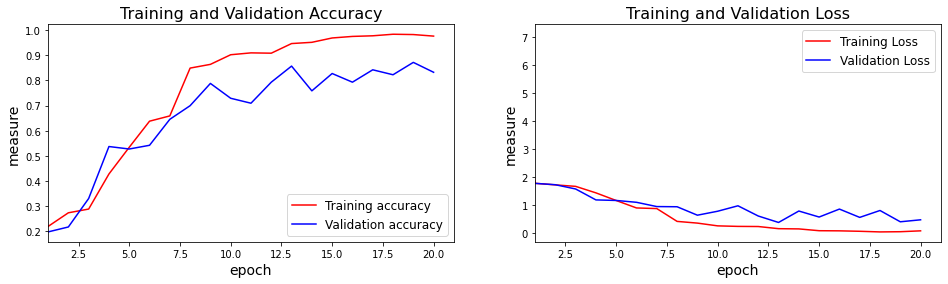

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()